# ML-CUP25: End-to-end Pipeline mit `network`
In diesem Notebook reproduzieren wir die Schritte aus dem MONK-Notebook für das ML-CUP25-Trainingsset:
- Laden & Vorbereiten der Daten (CSV)
- Einfaches Train/Val/Test-Training mit Lernkurven (MSE, R²)
- Nested Cross-Validation mit Grid Search (outer K-Folds, inner K-Folds)
- Visualisierung der Outer-Fold-Ergebnisse und der Grid-Auswahl
- Lernkurven für die beste Konfiguration

## Imports und Hilfsfunktionen
Wir verwenden ausschließlich NumPy, Pandas, Matplotlib und die `network`-Bausteine. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from network.dataset import Dataset
from network.dataloader import DataLoader
from network.model import Model
from network.linear import LinearLayer
from network.relu import ReLU
from network.mse import MSELoss
from network.adam import AdamWOptimizer

def r2_score_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)
    y_mean = y_true.mean()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_mean) ** 2)
    if ss_tot == 0:
        return 0.0
    return float(1.0 - ss_res / ss_tot)

# Mean Euclidean Error (MEE) gemäß Wettbewerbsdefinition
# E_MEE = (1/l) * sum_p ||o_p - t_p||_2
# (auf Originalskala der Targets; wir standardisieren Targets nur für Training,
#  und 'unscale' für MEE/Abgabe)
def mee_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    diffs = y_pred.astype(np.float64) - y_true.astype(np.float64)
    dists = np.sqrt(np.sum(diffs ** 2, axis=1))  # L2 je Pattern über 4 Targets
    return float(np.mean(dists))

def standardize_fit(X: np.ndarray):
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True) + 1e-8
    return mu, sigma

def standardize_apply(X: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
    return (X - mu) / sigma

def standardize_inverse(Xs: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
    return Xs * sigma + mu

def kfold_indices(n_samples: int, k: int, seed: int = 42, shuffle: bool = True):
    rng = np.random.default_rng(seed)
    idx = np.arange(n_samples)
    if shuffle:
        rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return [f.astype(int) for f in folds]

def build_model(input_dim: int, hidden_sizes, output_dim: int):
    layers = []
    in_dim = input_dim
    for h in hidden_sizes:
        layers.extend([LinearLayer(in_dim, h), ReLU()])
        in_dim = h
    layers.append(LinearLayer(in_dim, output_dim))
    return Model(*layers)

def make_loader(x, y, batch_size, shuffle):
    return DataLoader(Dataset(x, y), batch_size=batch_size, shuffle=shuffle)

# Helfer: Vorhersagen in Batches (ohne Targets nötig)
def predict_in_batches(model: Model, X_s: np.ndarray, batch_size: int) -> np.ndarray:
    loader = make_loader(X_s, np.zeros((X_s.shape[0], 1), dtype=np.float32), batch_size=batch_size, shuffle=False)
    preds = []
    for xb, _ in loader:
        yp = model.forward(xb)
        preds.append(yp)
    return np.concatenate(preds, axis=0)

def _copy_model(model: Model) -> Model:
    new_layers = []
    for layer in model.layers:
        if isinstance(layer, LinearLayer):
            new_l = LinearLayer(layer.input_size, layer.output_size)
            new_l.weights = layer.weights.copy()
            new_l.biases = layer.biases.copy()
            new_layers.append(new_l)
        else:
            new_layers.append(layer)
    return Model(*new_layers)

def train_one_config_reg(
    X_tr_raw: np.ndarray, y_tr_s: np.ndarray,
    X_val_raw: np.ndarray, y_val_s: np.ndarray,
    cfg: dict, seed: int = 0
 ):
    np.random.seed(seed)
    mu_x, sigma_x = standardize_fit(X_tr_raw)
    X_tr_s  = standardize_apply(X_tr_raw,  mu_x, sigma_x)
    X_val_s = standardize_apply(X_val_raw, mu_x, sigma_x)

    model = build_model(X_tr_s.shape[1], cfg['hidden_sizes'], y_tr_s.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=cfg['learning_rate'], weight_decay=cfg['weight_decay'])

    train_loader = make_loader(X_tr_s,  y_tr_s,  batch_size=cfg['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val_s, y_val_s, batch_size=cfg['batch_size'], shuffle=False)

    for _ in range(cfg['num_epochs']):
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()

    # Val MSE (scaled) als Selection Criterion
    val_losses = []
    preds_s, trues_s = [], []
    for xb, yb in val_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        val_losses.append(l)
        preds_s.append(yp)
        trues_s.append(yb)
    val_mse_s = float(np.mean(val_losses))

    p_full_s = np.concatenate(preds_s, axis=0)
    t_full_s = np.concatenate(trues_s, axis=0)
    val_r2_s = r2_score_np(t_full_s, p_full_s)

    best_model = _copy_model(model)
    return val_mse_s, val_r2_s, best_model, (mu_x, sigma_x)

def evaluate_test_reg(
    model: Model, X_te_raw: np.ndarray, y_te_s: np.ndarray,
    mu_sigma: tuple, batch_size: int
 ):
    mu_x, sigma_x = mu_sigma
    X_te_s = standardize_apply(X_te_raw, mu_x, sigma_x)
    te_loader = make_loader(X_te_s, y_te_s, batch_size=batch_size, shuffle=False)
    loss_fn = MSELoss()
    te_losses = []
    preds_s, trues_s = [], []
    for xb, yb in te_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        te_losses.append(l)
        preds_s.append(yp)
        trues_s.append(yb)
    te_mse_s = float(np.mean(te_losses))
    p_full_s = np.concatenate(preds_s, axis=0)
    t_full_s = np.concatenate(trues_s, axis=0)
    te_r2_s = r2_score_np(t_full_s, p_full_s)
    return te_mse_s, te_r2_s

## Daten laden (ML-CUP25-TR.csv)
Die CSV enthält:
- Erste Spalte: `ID`
- Feature-Spalten: alle Spalten nach `ID` bis zu den letzten 4
- Zielvariablen: die letzten 4 Spalten (`TARGET_1..4`)

Wir lesen die Datei mit `pandas.read_csv` und `comment="#"` (ignoriert Kopf-Kommentare).

In [8]:
# CSV einlesen
df = pd.read_csv('ML-CUP25-TR.csv', header=None, comment='#')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,-6.925642,-6.093158,-9.149763,-5.918488,4.391259,-1.059304,-5.031085,-6.932177,-5.805652,7.147028,4.555533,-5.694865,6.554997,10.688732,15.416160,-7.535628
1,2,-5.649870,-7.650998,-10.407383,-7.864047,3.790306,-1.673732,-8.493233,-8.143588,-9.447557,10.790796,6.266211,-5.551301,12.342252,-8.135250,23.787661,-3.270978
2,3,15.985886,14.192953,24.466835,12.551305,-7.788409,0.557977,23.145951,20.031774,14.516358,-21.024198,-10.410913,12.061133,28.542661,-14.132383,-56.408372,1.892238
3,4,12.774004,10.156462,18.588934,8.346695,-5.245173,-0.199274,14.500231,12.608063,12.411055,-15.479452,-8.871887,6.703585,20.253500,9.525402,-0.673842,40.295464
4,5,-4.019226,-4.043457,-5.095354,-3.147125,0.725466,-0.477673,-4.025913,-0.995364,-3.491760,3.385533,1.838361,-4.271710,-3.588910,6.050010,1.198489,-11.677909


In [9]:
# Predict for entire dataset (korrigierte Reihenfolge + konsistente Skalierung)
# Voraussetzungen:
# 1) X/y müssen aus df gebaut sein (Zelle 7).
# 2) y_mu/y_sigma müssen über y berechnet sein (Zelle 8).
# 3) model muss trainiert sein (z. B. nach Zelle 10, oder du trainierst final nochmal).

import numpy as np
import matplotlib.pyplot as plt

if 'X' not in globals() or 'y' not in globals():
    raise NameError("X/y sind nicht definiert. Bitte zuerst Zelle 7 (ID, X, y) ausführen.")
if 'y_mu' not in globals() or 'y_sigma' not in globals():
    raise NameError("y_mu/y_sigma sind nicht definiert. Bitte zuerst Zelle 8 (Targets skalieren) ausführen.")
if 'model' not in globals():
    raise NameError("model ist nicht definiert. Bitte zuerst das Training ausführen (ab Zelle 10) oder ein finales Modell trainieren.")

# Wichtig: Feature-Skalierung muss zu der Skalierung passen, mit der das Modell trainiert wurde.
# Falls du im Training mu/sigma (Features) als Variablen 'mu' und 'sigma' hast: nutze diese.
if 'mu' in globals() and 'sigma' in globals():
    mu_x, sigma_x = mu, sigma
else:
    # Fallback: passe Features an X-Full an (nicht ideal, aber lauffähig)
    mu_x, sigma_x = standardize_fit(X)

X_s = standardize_apply(X, mu_x, sigma_x)
preds_s = predict_in_batches(model, X_s, batch_size=256)

# Targets zurück in Originalskala (muss zu y_mu/y_sigma aus dem Training passen!)
preds = standardize_inverse(preds_s, y_mu, y_sigma)
true = y

targets = [f'TARGET_{i+1}' for i in range(true.shape[1])]
fig, axes = plt.subplots(1, true.shape[1], figsize=(16,4), squeeze=False)
for i, ax in enumerate(axes[0]):
    t = true[:, i]
    p = preds[:, i]
    ax.scatter(t, p, alpha=0.6, s=20)
    mn = float(min(t.min(), p.min()))
    mx = float(max(t.max(), p.max()))
    ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
    r2 = r2_score_np(t.reshape(-1,1), p.reshape(-1,1))
    ax.set_title(f'{targets[i]} (R2={r2:.3f})')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

NameError: model ist nicht definiert. Bitte zuerst das Training ausführen (ab Zelle 10) oder ein finales Modell trainieren.

In [ ]:
# Aufteilen in ID, X, y
ID = df.iloc[:, 0].to_numpy()
X  = df.iloc[:, 1:-4].astype(np.float32).to_numpy()
y  = df.iloc[:, -4:].astype(np.float32).to_numpy()
X.shape, y.shape

((500, 12), (500, 4))

In [ ]:
# Targets skalieren (für stabileres Training)
y_mu, y_sigma = standardize_fit(y)
y_s = standardize_apply(y, y_mu, y_sigma)

print('y mean (raw):', y.mean(axis=0))
print('y std  (raw):', y.std(axis=0))
print('y mean (scaled):', y_s.mean(axis=0))
print('y std  (scaled):', y_s.std(axis=0))

y mean (raw): [ 0.38942823 -0.32729527 -3.9026423   3.5399203 ]
y std  (raw): [14.499411 14.634983 22.776648 22.803625]
y mean (scaled): [-7.6293949e-09  1.9073487e-09  9.5367436e-10  1.9073487e-09]
y std  (scaled): [0.99999994 1.         1.         1.        ]


## Einfaches Train/Val/Test-Training mit Lernkurven
Wir führen ein klassisches Training mit festem Split durch:
- Standardisierung der Features anhand des Trainingssplits (ohne Leakage).
- Modell: zwei versteckte Schichten.
- Tracking: Train/Val MSE und Val-R² je Epoche.

In [ ]:
# Fester Split (Features) + Targets-Skalierung
n_total = X.shape[0]
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

X_train, y_train = X[:n_train],               y_s[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val],  y_s[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:],         y_s[n_train+n_val:]

# Standardisierung nur basierend auf Training (Features)
mu, sigma = standardize_fit(X_train)
X_train_s = standardize_apply(X_train, mu, sigma)
X_val_s   = standardize_apply(X_val,   mu, sigma)
X_test_s  = standardize_apply(X_test,  mu, sigma)

# Dataloader
train_loader = make_loader(X_train_s, y_train, batch_size=32, shuffle=True)
val_loader   = make_loader(X_val_s,   y_val,   batch_size=32, shuffle=False)

# Modell + Training
input_dim  = X_train_s.shape[1]
output_dim = y_train.shape[1]
model = build_model(input_dim, hidden_sizes=(32,), output_dim=output_dim)
loss_fn = MSELoss()
optimizer = AdamWOptimizer(model, learning_rate=0.003, weight_decay=0.0005)

num_epochs = 150
train_loss_history = []
val_loss_history   = []
val_r2_history     = []
val_mee_history    = []

for epoch in range(num_epochs):
    # Train
    train_losses = []
    for xb, yb in train_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        g  = loss_fn.backward()
        model.backward(g)
        optimizer.step()
        train_losses.append(l)

    # Val
    val_losses = []
    preds = []
    trues = []
    for xb, yb in val_loader:
        yp = model.forward(xb)
        l  = loss_fn.forward(yp, yb)
        val_losses.append(l)
        preds.append(yp)
        trues.append(yb)

    mean_train = float(np.mean(train_losses))
    mean_val   = float(np.mean(val_losses))

    p_full_s = np.concatenate(preds, axis=0)
    t_full_s = np.concatenate(trues, axis=0)

    # Für interpretierbare Metriken zurück in Originalskala
    p_full = standardize_inverse(p_full_s, y_mu, y_sigma)
    t_full = standardize_inverse(t_full_s, y_mu, y_sigma)

    val_r2 = r2_score_np(t_full, p_full)
    val_mee = mee_np(t_full, p_full)

    train_loss_history.append(mean_train)
    val_loss_history.append(mean_val)
    val_r2_history.append(val_r2)
    val_mee_history.append(val_mee)

    print(f"Epoch {epoch+1:03d} | TrainLoss(scaled)={mean_train:.4f} | ValLoss(scaled)={mean_val:.4f} | ValR2={val_r2:.4f} | ValMEE={val_mee:.4f}")

# Testbewertung
test_loader = make_loader(X_test_s, y_test, batch_size=32, shuffle=False)
test_losses = []
preds = []
trues = []
for xb, yb in test_loader:
    yp = model.forward(xb)
    l  = loss_fn.forward(yp, yb)
    test_losses.append(l)
    preds.append(yp)
    trues.append(yb)

test_loss_scaled = float(np.mean(test_losses))
p_full_s = np.concatenate(preds, axis=0)
t_full_s = np.concatenate(trues, axis=0)

p_full = standardize_inverse(p_full_s, y_mu, y_sigma)
t_full = standardize_inverse(t_full_s, y_mu, y_sigma)

test_r2 = r2_score_np(t_full, p_full)
test_mee = mee_np(t_full, p_full)
print(f"TestLoss(scaled)={test_loss_scaled:.4f} | TestR2={test_r2:.4f} | TestMEE={test_mee:.4f}")

Epoch 001 | TrainLoss(scaled)=1.4840 | ValLoss(scaled)=0.9047 | ValR2=0.3150 | ValMEE=30.3942
Epoch 002 | TrainLoss(scaled)=0.7410 | ValLoss(scaled)=0.7606 | ValR2=0.3974 | ValMEE=28.0659
Epoch 003 | TrainLoss(scaled)=0.7224 | ValLoss(scaled)=0.7341 | ValR2=0.4281 | ValMEE=27.4402
Epoch 004 | TrainLoss(scaled)=0.6773 | ValLoss(scaled)=0.7435 | ValR2=0.4328 | ValMEE=27.5487
Epoch 005 | TrainLoss(scaled)=0.6709 | ValLoss(scaled)=0.7537 | ValR2=0.4247 | ValMEE=27.5560
Epoch 006 | TrainLoss(scaled)=0.6348 | ValLoss(scaled)=0.6994 | ValR2=0.4687 | ValMEE=26.7315
Epoch 007 | TrainLoss(scaled)=0.6404 | ValLoss(scaled)=0.7070 | ValR2=0.4577 | ValMEE=26.9413
Epoch 008 | TrainLoss(scaled)=0.6308 | ValLoss(scaled)=0.7164 | ValR2=0.4503 | ValMEE=27.0633
Epoch 009 | TrainLoss(scaled)=0.6070 | ValLoss(scaled)=0.6767 | ValR2=0.4853 | ValMEE=26.3332
Epoch 010 | TrainLoss(scaled)=0.6105 | ValLoss(scaled)=0.6997 | ValR2=0.4603 | ValMEE=26.7700
Epoch 011 | TrainLoss(scaled)=0.6018 | ValLoss(scaled)=0.670

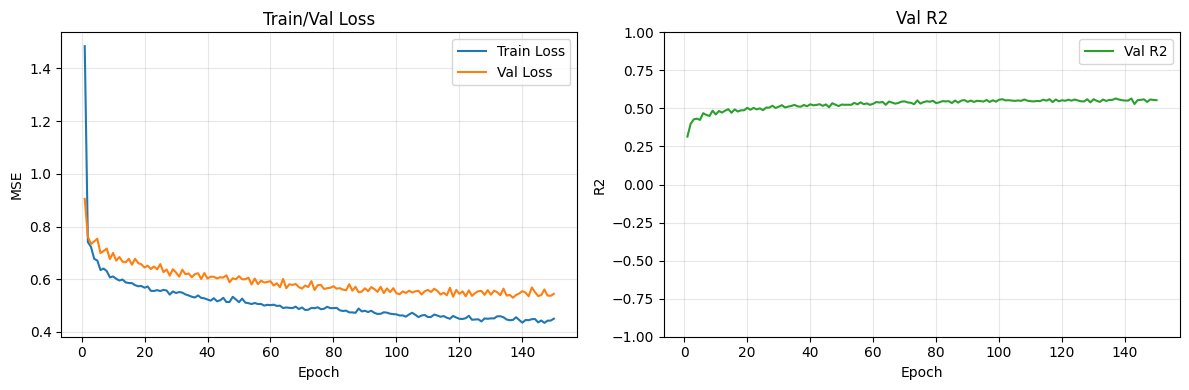

In [ ]:
# Lernkurven-Plot (MSE & R2)
epochs = np.arange(1, len(train_loss_history)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Train/Val Loss'); plt.grid(alpha=0.3); plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, val_r2_history, color='tab:green', label='Val R2')
plt.xlabel('Epoch'); plt.ylabel('R2'); plt.title('Val R2'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

## Nested Cross-Validation + Grid Search
Verschachtelte Validierung zur robusten Hyperparameterwahl:
- Outer K-Folds: hold-out Test je Fold.
- Inner K-Folds: Grid Search mit mittlerem inneren Val-Loss als Auswahlkriterium.
- Evaluierung: Test-Loss und Test-R² je Outer-Fold; Mittelwerte am Ende.
- Visualisierungen: Balkendiagramme (Loss/R²), Heatmaps der Auswahlhäufigkeit.

In [ ]:
# Kleines Grid für Nested-CV (Targets werden pro Fold skaliert)
param_grid = {
    'hidden_sizes': [ (8,), (16,), (16,8), (32,) ],
    'learning_rate': [ 0.001, 0.003 ],
    'weight_decay': [ 0.0, 0.0005 ],
    'batch_size': [ 32 ],
    'num_epochs': [ 120 ]
}

grid_configs = []
for hs in param_grid['hidden_sizes']:
    for lr in param_grid['learning_rate']:
        for wd in param_grid['weight_decay']:
            for bs in param_grid['batch_size']:
                for ne in param_grid['num_epochs']:
                    grid_configs.append({
                        'hidden_sizes': hs,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'batch_size': bs,
                        'num_epochs': ne,
                    })

k_outer, k_inner = 5, 3
print(f"Nested CV: outer={k_outer}, inner={k_inner}, grid={len(grid_configs)} → Läufe {k_outer*len(grid_configs)*k_inner}")

N = X.shape[0]
outer_folds = kfold_indices(N, k_outer, seed=123, shuffle=True)
outer_results = []

for ofi in range(k_outer):
    test_idx    = outer_folds[ofi]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != ofi])
    X_trainval_raw, y_trainval_raw = X[trainval_idx], y[trainval_idx]
    X_test_o_raw,   y_test_o_raw   = X[test_idx],     y[test_idx]

    # Targets-Skalierung nur aus Train+Val des Outer-Folds
    y_mu_o, y_sigma_o = standardize_fit(y_trainval_raw)
    y_trainval = standardize_apply(y_trainval_raw, y_mu_o, y_sigma_o)
    y_test_o   = standardize_apply(y_test_o_raw,   y_mu_o, y_sigma_o)

    # Inner folds auf Train+Val
    inner_folds = kfold_indices(X_trainval_raw.shape[0], k_inner, seed=321+ofi, shuffle=True)
    cfg_scores = []
    for cfg in grid_configs:
        inner_vals = []
        for ifi in range(k_inner):
            val_i = inner_folds[ifi]
            tr_i  = np.concatenate([inner_folds[j] for j in range(k_inner) if j != ifi])
            mv, r2v, _, _ = train_one_config_reg(
                X_trainval_raw[tr_i], y_trainval[tr_i],
                X_trainval_raw[val_i], y_trainval[val_i],
                cfg, seed=42+ifi
            )
            inner_vals.append(mv)
        cfg_scores.append((cfg, float(np.mean(inner_vals))))
    cfg_scores.sort(key=lambda x: x[1])
    best_cfg, best_inner = cfg_scores[0]

    # Retrain auf komplettem Train+Val und testen auf Outer-Test
    mv, _, best_model, mu_sigma = train_one_config_reg(
        X_trainval_raw, y_trainval, X_test_o_raw, y_test_o, best_cfg, seed=999
    )
    te_loss_s, _ = evaluate_test_reg(best_model, X_test_o_raw, y_test_o, mu_sigma, batch_size=best_cfg['batch_size'])

    # Für MEE & R² in Originalskala: Vorhersage (skaliert) → zurückskalieren
    mu_x, sigma_x = mu_sigma
    X_test_s = standardize_apply(X_test_o_raw, mu_x, sigma_x)
    p_full_s = predict_in_batches(best_model, X_test_s, best_cfg['batch_size'])
    p_full = standardize_inverse(p_full_s, y_mu_o, y_sigma_o)

    te_mee = mee_np(y_test_o_raw, p_full)
    te_r2  = r2_score_np(y_test_o_raw, p_full)

    print(
        f"[Outer {ofi+1}/{k_outer}] best={best_cfg} | "
        f"inner mean ValLoss(MSE scaled)={best_inner:.4f} | "
        f"TestLoss(MSE scaled)={te_loss_s:.4f} | "
        f"TestMEE(original)={te_mee:.4f} | TestR2(original)={te_r2:.4f}"
    )

    outer_results.append({
        'outer_fold': ofi,
        'best_cfg': best_cfg,
        'inner_mean_val_mse_scaled': best_inner,
        'test_mse_scaled': te_loss_s,
        'test_r2': te_r2,
        'test_mee': te_mee,
        'y_mu_sigma': (y_mu_o, y_sigma_o),
    })

mean_test_mee = float(np.mean([r['test_mee'] for r in outer_results]))
mean_test_r2  = float(np.mean([r['test_r2']  for r in outer_results]))
mean_test_mse_scaled = float(np.mean([r['test_mse_scaled'] for r in outer_results]))
print("\n=== Outer-Fold Mittelwerte ===")
print(f"Mean TestMSE (scaled): {mean_test_mse_scaled:.4f}")
print(f"Mean TestMEE (original): {mean_test_mee:.4f}")
print(f"Mean TestR2  (original): {mean_test_r2:.4f}")

Nested CV: outer=5, inner=3, grid=16 → Läufe 240
[Outer 1/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss(MSE scaled)=0.4928 | TestLoss(MSE scaled)=0.6119 | TestMEE(original)=24.7356 | TestR2(original)=0.5271
[Outer 1/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss(MSE scaled)=0.4928 | TestLoss(MSE scaled)=0.6119 | TestMEE(original)=24.7356 | TestR2(original)=0.5271
[Outer 2/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss(MSE scaled)=0.5149 | TestLoss(MSE scaled)=0.5306 | TestMEE(original)=24.3216 | TestR2(original)=0.5331
[Outer 2/5] best={'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120} | inner mean ValLoss(MSE scaled)=0.5149 | TestLoss(MSE scaled)=0.5306 | TestMEE(origina

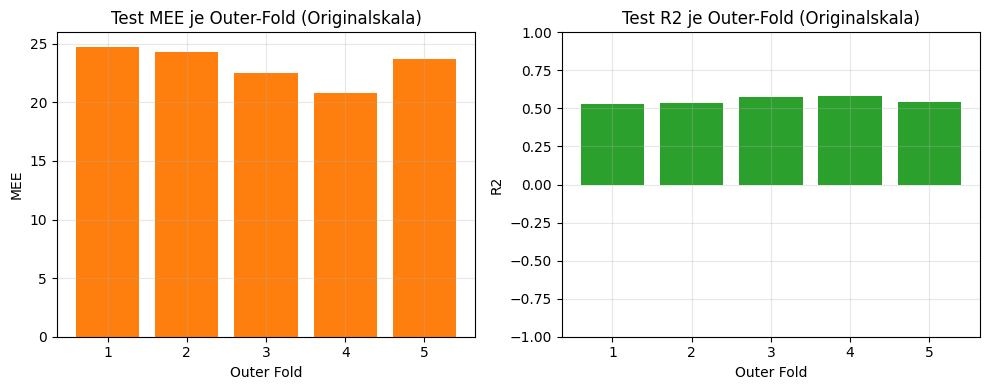

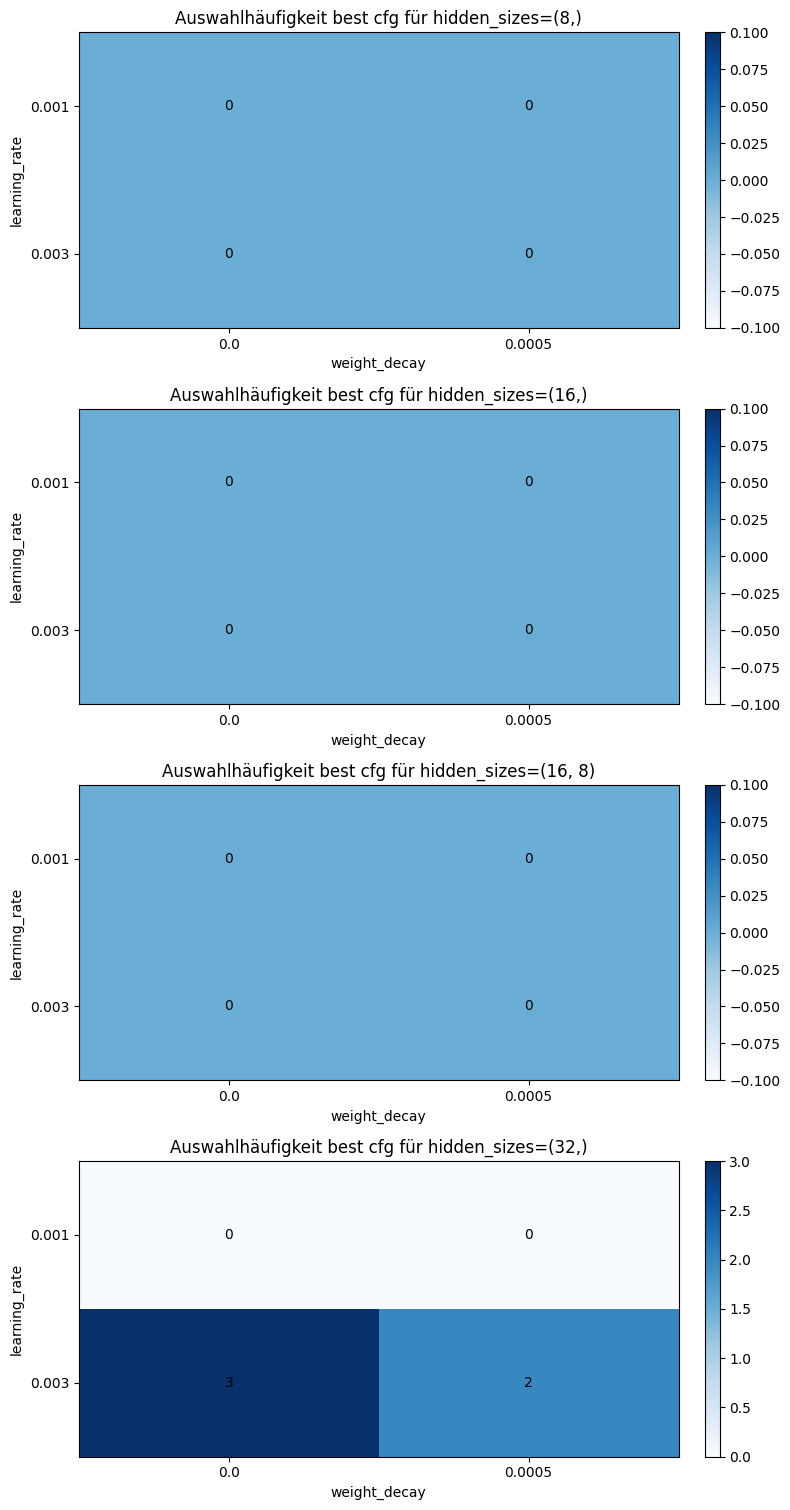

In [ ]:
# Visualisierung der Outer-Fold-Ergebnisse und Grid-Häufigkeiten
from collections import defaultdict

fold_ids   = [r['outer_fold']+1 for r in outer_results]
test_mees  = [r['test_mee'] for r in outer_results]
test_r2s   = [r['test_r2']  for r in outer_results]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(fold_ids, test_mees, color='tab:orange')
plt.title('Test MEE je Outer-Fold (Originalskala)')
plt.xlabel('Outer Fold'); plt.ylabel('MEE'); plt.grid(alpha=0.3)
plt.subplot(1,2,2)
plt.bar(fold_ids, test_r2s, color='tab:green')
plt.title('Test R2 je Outer-Fold (Originalskala)')
plt.xlabel('Outer Fold'); plt.ylabel('R2'); plt.ylim(-1.0, 1.0); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Heatmap der Auswahlhäufigkeit (hidden_sizes vs (lr, wd))
hs_list = sorted(list({tuple(cfg['hidden_sizes']) for cfg in grid_configs}))
lr_list = sorted(list({cfg['learning_rate'] for cfg in grid_configs}))
wd_list = sorted(list({cfg['weight_decay']  for cfg in grid_configs}))
freq = defaultdict(int)
for r in outer_results:
    cfg = r['best_cfg']
    key = (tuple(cfg['hidden_sizes']), cfg['learning_rate'], cfg['weight_decay'])
    freq[key] += 1

n_rows = len(hs_list)
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 3.8*n_rows), squeeze=False)
for i, hs in enumerate(hs_list):
    mat = np.zeros((len(lr_list), len(wd_list)), dtype=float)
    for rr, lr in enumerate(lr_list):
        for cc, wd in enumerate(wd_list):
            mat[rr, cc] = freq.get((hs, lr, wd), 0)
    ax = axes[i, 0]
    im = ax.imshow(mat, cmap='Blues', aspect='auto')
    ax.set_title(f'Auswahlhäufigkeit best cfg für hidden_sizes={hs}')
    ax.set_xticks(np.arange(len(wd_list))); ax.set_xticklabels([str(wd) for wd in wd_list])
    ax.set_yticks(np.arange(len(lr_list))); ax.set_yticklabels([str(lr) for lr in lr_list])
    ax.set_xlabel('weight_decay'); ax.set_ylabel('learning_rate')
    for rr in range(len(lr_list)):
        for cc in range(len(wd_list)):
            ax.text(cc, rr, f"{int(mat[rr, cc])}", ha='center', va='center', color='black')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

## Lernkurven (best cfg)
Wir trainieren die beste Konfiguration erneut (auf Train+Val aus einem Outer-Fold) und zeichnen Train/Val-Loss sowie Val-R² über die Epochen auf.

## Optimierungen: Early Stopping, erweitertes Grid, per-Target-R² und LR-Decay
Die bisherigen Kurven zeigen, dass das Modell zwar lernt, aber die Generalisierung schwach ist. Wir ergänzen:
- Early Stopping mit Patience zur Vermeidung von Overfitting.
- Größeres Grid (mehr Hidden-Sizes, längere Trainingsdauer) – bei Bedarf reduzieren.
- Per-Target-R², um zu sehen, ob einzelne Ziele besser/schlechter modelliert werden.
- Einfaches Learning-Rate-Decay (halbiere LR, wenn Val-Loss eine Weile nicht besser wird).

Hinweis: Laufzeit steigt. Du kannst die Parameter (Patience, Epochen, Grid) anpassen.

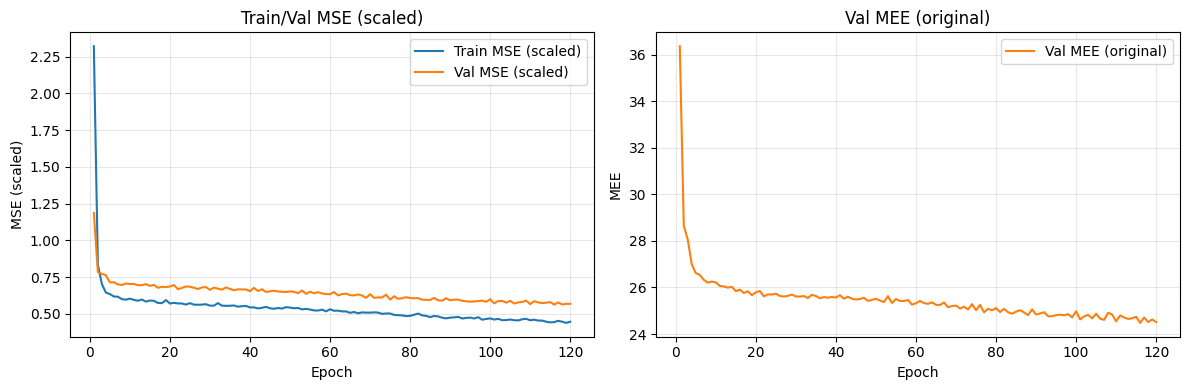

In [ ]:
# Neutraining mit best_cfg für Lernkurven (einheitlich: y skaliert, MEE/R2 original)

def train_with_hist_reg(X_tr, y_tr_raw, X_val, y_val_raw, cfg, seed=777):
    np.random.seed(seed)

    # Feature-Skalierung
    mu_x, sigma_x = standardize_fit(X_tr)
    X_tr_s  = standardize_apply(X_tr,  mu_x, sigma_x)
    X_val_s = standardize_apply(X_val, mu_x, sigma_x)

    # Target-Skalierung (nur aus Train)
    y_mu, y_sigma = standardize_fit(y_tr_raw)
    y_tr_s  = standardize_apply(y_tr_raw,  y_mu, y_sigma)
    y_val_s = standardize_apply(y_val_raw, y_mu, y_sigma)

    model = build_model(X_tr_s.shape[1], cfg['hidden_sizes'], y_tr_s.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=cfg['learning_rate'], weight_decay=cfg['weight_decay'])

    train_loader = make_loader(X_tr_s,  y_tr_s,  batch_size=cfg['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val_s, y_val_s, batch_size=cfg['batch_size'], shuffle=False)

    tr_mse_s_hist, va_mse_s_hist = [], []
    va_mee_hist, va_r2_hist = [], []

    for _ in range(cfg['num_epochs']):
        # Train (scaled MSE)
        t_losses = []
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
            t_losses.append(l)

        # Val
        v_losses = []
        preds_s, trues_s = [], []
        for xb, yb in val_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            v_losses.append(l)
            preds_s.append(yp)
            trues_s.append(yb)

        tr_mse_s = float(np.mean(t_losses))
        va_mse_s = float(np.mean(v_losses))

        p_full_s = np.concatenate(preds_s, axis=0)
        t_full_s = np.concatenate(trues_s, axis=0)

        # Originalskala für MEE/R²
        p_full = standardize_inverse(p_full_s, y_mu, y_sigma)
        t_full = standardize_inverse(t_full_s, y_mu, y_sigma)

        tr_mse_s_hist.append(tr_mse_s)
        va_mse_s_hist.append(va_mse_s)
        va_mee_hist.append(mee_np(t_full, p_full))
        va_r2_hist.append(r2_score_np(t_full, p_full))

    return {
        'train_mse_scaled': tr_mse_s_hist,
        'val_mse_scaled': va_mse_s_hist,
        'val_mee': va_mee_hist,
        'val_r2': va_r2_hist,
        'y_mu_sigma': (y_mu, y_sigma),
        'x_mu_sigma': (mu_x, sigma_x),
        'model': model,
    }

# Safeguard: erfordert, dass outer_results vorher erzeugt wurden
if len(outer_results) > 0:
    # Wähle exemplarisch den ersten Outer-Fold und best_cfg davon
    best_cfg = outer_results[0]['best_cfg']

    # Erzeuge denselben Split (für Demonstration)
    test_idx = outer_folds[0]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != 0])
    X_trainval, y_trainval_raw = X[trainval_idx], y[trainval_idx]
    X_test_o,   y_test_o_raw   = X[test_idx],     y[test_idx]

    hist = train_with_hist_reg(X_trainval, y_trainval_raw, X_test_o, y_test_o_raw, best_cfg, seed=2025)
    epochs = np.arange(1, len(hist['train_mse_scaled'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['train_mse_scaled'], label='Train MSE (scaled)')
    plt.plot(epochs, hist['val_mse_scaled'],   label='Val MSE (scaled)')
    plt.xlabel('Epoch'); plt.ylabel('MSE (scaled)'); plt.title('Train/Val MSE (scaled)'); plt.grid(alpha=0.3); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['val_mee'], color='tab:orange', label='Val MEE (original)')
    plt.xlabel('Epoch'); plt.ylabel('MEE'); plt.title('Val MEE (original)'); plt.grid(alpha=0.3); plt.legend()

    plt.tight_layout(); plt.show()
else:
    print('Bitte zuerst die Nested-CV-Zelle ausführen, damit outer_results verfügbar ist.')

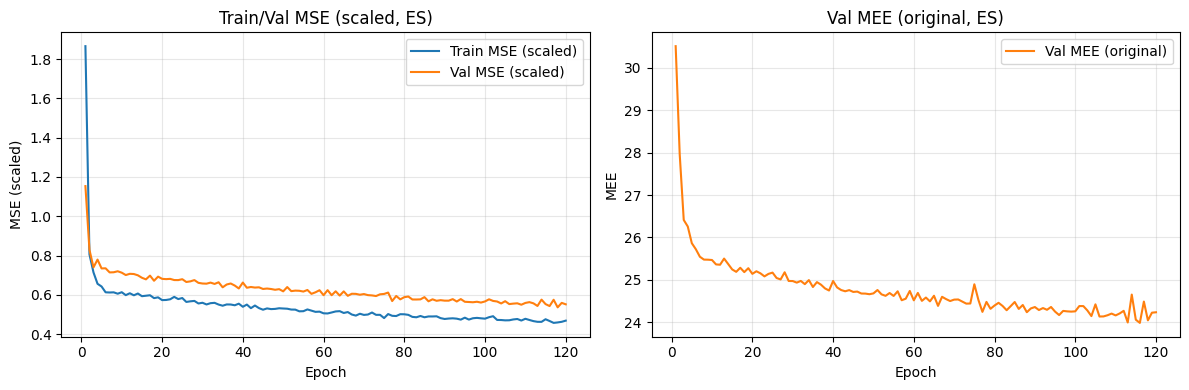

In [ ]:
# Early-Stopping-Training mit LR-Decay (einheitlich: y skaliert, MEE/R2 original)

def train_with_early_stopping_reg(X_tr, y_tr_raw, X_val, y_val_raw, cfg, seed=777, patience=10, lr_decay_factor=0.5, lr_decay_patience=8):
    np.random.seed(seed)

    # Feature-Skalierung
    mu_x, sigma_x = standardize_fit(X_tr)
    X_tr_s  = standardize_apply(X_tr,  mu_x, sigma_x)
    X_val_s = standardize_apply(X_val, mu_x, sigma_x)

    # Target-Skalierung (nur aus Train)
    y_mu, y_sigma = standardize_fit(y_tr_raw)
    y_tr_s  = standardize_apply(y_tr_raw,  y_mu, y_sigma)
    y_val_s = standardize_apply(y_val_raw, y_mu, y_sigma)

    model = build_model(X_tr_s.shape[1], cfg['hidden_sizes'], y_tr_s.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=cfg['learning_rate'], weight_decay=cfg['weight_decay'])

    train_loader = make_loader(X_tr_s,  y_tr_s,  batch_size=cfg['batch_size'], shuffle=True)
    val_loader   = make_loader(X_val_s, y_val_s, batch_size=cfg['batch_size'], shuffle=False)

    tr_mse_s_hist, va_mse_s_hist = [], []
    va_mee_hist, va_r2_hist = [], []

    best_val = float('inf')
    best_state = None
    epochs_no_improve = 0
    epochs_no_lr_improve = 0
    current_lr = cfg['learning_rate']

    for _ in range(cfg['num_epochs']):
        # Train
        t_losses = []
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
            t_losses.append(l)

        # Val
        v_losses = []
        preds_s, trues_s = [], []
        for xb, yb in val_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            v_losses.append(l)
            preds_s.append(yp); trues_s.append(yb)

        tr_mse_s = float(np.mean(t_losses))
        va_mse_s = float(np.mean(v_losses))

        p_full_s = np.concatenate(preds_s, axis=0)
        t_full_s = np.concatenate(trues_s, axis=0)

        # Metriken in Originalskala
        p_full = standardize_inverse(p_full_s, y_mu, y_sigma)
        t_full = standardize_inverse(t_full_s, y_mu, y_sigma)

        tr_mse_s_hist.append(tr_mse_s)
        va_mse_s_hist.append(va_mse_s)
        va_mee_hist.append(mee_np(t_full, p_full))
        va_r2_hist.append(r2_score_np(t_full, p_full))

        # Early Stopping (auf scaled Val-MSE)
        if va_mse_s < best_val - 1e-6:
            best_val = va_mse_s
            best_state = (model, mu_x, sigma_x, y_mu, y_sigma)
            epochs_no_improve = 0
            epochs_no_lr_improve = 0
        else:
            epochs_no_improve += 1
            epochs_no_lr_improve += 1

        # LR-Decay
        if epochs_no_lr_improve >= lr_decay_patience:
            current_lr *= lr_decay_factor
            optimizer.learning_rate = current_lr
            epochs_no_lr_improve = 0

        # Stoppen
        if epochs_no_improve >= patience:
            break

    if best_state is None:
        best_state = (model, mu_x, sigma_x, y_mu, y_sigma)

    return {
        'model': best_state[0],
        'x_mu_sigma': (best_state[1], best_state[2]),
        'y_mu_sigma': (best_state[3], best_state[4]),
        'train_mse_scaled': tr_mse_s_hist,
        'val_mse_scaled': va_mse_s_hist,
        'val_mee': va_mee_hist,
        'val_r2': va_r2_hist,
    }

# Demo: verwende best_cfg und denselben Outer-Split wie zuvor, aber mit Early Stopping
if len(outer_results) > 0:
    best_cfg = outer_results[0]['best_cfg']
    test_idx = outer_folds[0]
    trainval_idx = np.concatenate([outer_folds[j] for j in range(k_outer) if j != 0])
    X_trainval, y_trainval_raw = X[trainval_idx], y[trainval_idx]
    X_test_o,   y_test_o_raw   = X[test_idx],     y[test_idx]

    hist_es = train_with_early_stopping_reg(
        X_trainval, y_trainval_raw, X_test_o, y_test_o_raw,
        best_cfg, seed=2026, patience=12, lr_decay_factor=0.5, lr_decay_patience=10
    )
    epochs = np.arange(1, len(hist_es['train_mse_scaled'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist_es['train_mse_scaled'], label='Train MSE (scaled)')
    plt.plot(epochs, hist_es['val_mse_scaled'],   label='Val MSE (scaled)')
    plt.xlabel('Epoch'); plt.ylabel('MSE (scaled)'); plt.title('Train/Val MSE (scaled, ES)'); plt.grid(alpha=0.3); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist_es['val_mee'], color='tab:orange', label='Val MEE (original)')
    plt.xlabel('Epoch'); plt.ylabel('MEE'); plt.title('Val MEE (original, ES)'); plt.grid(alpha=0.3); plt.legend()

    plt.tight_layout(); plt.show()
else:
    print('Bitte zuerst die Nested-CV-Zelle ausführen, damit outer_results verfügbar ist.')

## Inferenz auf dem Blind-Testset (ML-CUP25-TS.csv)
Diese Zelle lädt das Blind-Testset und berechnet Vorhersagen mit dem besten Modell aus der Nested-CV.
Hinweise:
- Das TS-Set enthält keine Targets; wir erzeugen nur `y_pred`.
- Standardisierung: verwendet die `mu/sigma` aus dem finalen Training des besten Modells (kein Leakage).
- Optional: Speichern der Predictions als CSV mit den zugehörigen IDs.

In [ ]:
# Laden des Blind-Testsets
df_ts = pd.read_csv('ML-CUP25-TS.csv', header=None, comment='#')
ID_ts = df_ts.iloc[:, 0].to_numpy()
X_ts  = df_ts.iloc[:, 1:].astype(np.float32).to_numpy()
print('TS shapes:', ID_ts.shape, X_ts.shape)

# Inferenz mit best_cfg und erneut trainiertem Modell
if len(outer_results) > 0:
    # Auswahl: beste Konfiguration nach minimalem Test-MEE über Outer-Folds
    best_idx = int(np.argmin([r['test_mee'] for r in outer_results]))
    best_cfg = outer_results[best_idx]['best_cfg']
    print('Verwende best_cfg aus Outer-Fold', best_idx+1, ':', best_cfg)
    
    # Standardisierung Features aus gesamtem Train
    mu_x, sigma_x = standardize_fit(X)
    X_s = standardize_apply(X,  mu_x, sigma_x)
    X_ts_s = standardize_apply(X_ts, mu_x, sigma_x)
    
    # Targets-Skalierung aus gesamtem Train
    y_mu, y_sigma = standardize_fit(y)
    y_s = standardize_apply(y, y_mu, y_sigma)
    
    # Trainiere final auf dem gesamten Trainingsdatensatz (X_s, y_s)
    model = build_model(X_s.shape[1], best_cfg['hidden_sizes'], y.shape[1])
    loss_fn = MSELoss()
    optimizer = AdamWOptimizer(model, learning_rate=best_cfg['learning_rate'], weight_decay=best_cfg['weight_decay'])
    train_loader = make_loader(X_s, y_s, batch_size=best_cfg['batch_size'], shuffle=True)
    for _ in range(best_cfg['num_epochs']):
        for xb, yb in train_loader:
            yp = model.forward(xb)
            l  = loss_fn.forward(yp, yb)
            g  = loss_fn.backward()
            model.backward(g)
            optimizer.step()
    
    # Vorhersagen auf TS (skaliert) → zurückskalieren
    preds_ts_s = []
    ts_loader = make_loader(X_ts_s, np.zeros((X_ts_s.shape[0], y.shape[1]), dtype=np.float32), batch_size=256, shuffle=False)
    for xb, _ in ts_loader:
        yp = model.forward(xb)
        preds_ts_s.append(yp)
    Y_ts_pred_s = np.concatenate(preds_ts_s, axis=0)
    Y_ts_pred = standardize_inverse(Y_ts_pred_s, y_mu, y_sigma)
    print('Y_ts_pred shape:', Y_ts_pred.shape)
    
    # Speichern als CSV: ID und vier Targets
    out = pd.DataFrame(Y_ts_pred, columns=[f'TARGET_{i+1}' for i in range(Y_ts_pred.shape[1])])
    out.insert(0, 'ID', ID_ts)
    out.to_csv('ML-CUP25-TS-predictions.csv', index=False)
    print('Predictions gespeichert in ML-CUP25-TS-predictions.csv')
else:
    print('Bitte erst Nested-CV ausführen, damit outer_results/best_cfg verfügbar sind.')

TS shapes: (1000,) (1000, 12)
Verwende best_cfg aus Outer-Fold 4 : {'hidden_sizes': (32,), 'learning_rate': 0.003, 'weight_decay': 0.0, 'batch_size': 32, 'num_epochs': 120}
Y_ts_pred shape: (1000, 4)
Predictions gespeichert in ML-CUP25-TS-predictions.csv
Y_ts_pred shape: (1000, 4)
Predictions gespeichert in ML-CUP25-TS-predictions.csv
